## Pricing of european call option prices using ANN in a BS setting

### Project overview:

<ol>
<li>Creation of the dataset of option prices</li>
<li>Model creation & fitting</li>
<li>Prediction errors visualization</li>
</ol>


In [286]:
import keras
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### 1.Creation of the dataset

In [287]:
#The function to replicate (compute the price/k of the option), we do that to have a model the most general possible
def black_scholes_call(SoverK, T, r, sigma):
    d1 = (np.log(SoverK) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call_price = SoverK * norm.cdf(d1) - 1 * np.exp(-r * T) * norm.cdf(d2)
    return call_price

In [288]:
#Creating the dataset
size = 10000
SoverKs = np.random.uniform(0.4, 1.6, size=size) #random prices
maturities = np.random.uniform(0.2, 1.1, size=size)
sigmas = np.random.uniform(0.01, 0.9, size=size)
rates = np.random.uniform(0.02, 0.1, size=size)
calls = np.array([black_scholes_call(SoverK, T, r, sigma) for (SoverK, T, r, sigma) in zip(SoverKs, maturities, rates, sigmas)])

In [289]:
data = pd.DataFrame()
data["SoverK"] = SoverKs
data["Maturity"] = maturities
data["Volatility"] = sigmas
data["RFR"] = rates
data["Call Price"] = calls
data

,SoverK,Maturity,Volatility,RFR,Call Price
0,0.837792,0.311489,0.570902,0.028633,0.054647
1,1.413583,1.016465,0.218181,0.074776,0.489410
2,0.963467,0.225283,0.508161,0.056305,0.082149
3,1.066772,0.977831,0.863645,0.049431,0.393584
4,1.351475,0.478531,0.534175,0.083482,0.430732
...,...,...,...,...,...
9995,1.162753,0.551324,0.393393,0.067032,0.247373
9996,0.724633,0.738674,0.108246,0.041602,0.000019
9997,1.106752,0.230400,0.662045,0.044219,0.198791
9998,0.411451,1.066804,0.605262,0.031168,0.015009


### 2.Model Creation & fitting


|Model Input| Model Output|
|:-------:|:-----:|
|StockPrice/Strike|Option Price/Strike|
|Time to maturity|
|RFR|
|volatility|

In [290]:
train, test = train_test_split(data, test_size=0.25)
train_x = train[["SoverK", "Maturity", "Volatility", "RFR"]]
train_y = np.array(train["Call Price"]).reshape(len(train["Call Price"]),1)
test_x = test[["SoverK", "Maturity", "Volatility", "RFR"]]
test_y = np.array(test["Call Price"]).reshape(len(test["Call Price"]),1)

In [291]:
# scaler_x = StandardScaler()
# train_x = scaler_x.fit_transform(train_x)
# test_x = scaler_x.transform(test_x)

In [292]:
model = keras.Sequential(
    [
    keras.layers.Dense(400, activation='relu', input_dim=train_x.shape[1], kernel_initializer="glorot_uniform"),
    keras.layers.Dense(400, activation='relu'),
    keras.layers.Dense(400, activation='relu'),
    keras.layers.Dense(400, activation='relu'),
    keras.layers.Dense(400, activation='relu'),
    keras.layers.Dense(1)
    ]
)


In [293]:
model.compile(loss='mse', optimizer='adam')

In [294]:
model.fit(train_x, train_y, epochs=500, batch_size=7500, validation_split=0.0, verbose=1)

Epoch 1/500
1/1 [==============================] - 1s 618ms/step - loss: 0.0786
Epoch 2/500
1/1 [==============================] - 0s 243ms/step - loss: 0.0319
Epoch 3/500
1/1 [==============================] - 0s 235ms/step - loss: 0.0321
Epoch 4/500
1/1 [==============================] - 0s 291ms/step - loss: 0.0252
Epoch 5/500
1/1 [==============================] - 0s 214ms/step - loss: 0.0245
Epoch 6/500
1/1 [==============================] - 0s 221ms/step - loss: 0.0190
Epoch 7/500
1/1 [==============================] - 0s 220ms/step - loss: 0.0205
Epoch 8/500
1/1 [==============================] - 0s 211ms/step - loss: 0.0156
Epoch 9/500
1/1 [==============================] - 0s 216ms/step - loss: 0.0177
Epoch 10/500
1/1 [==============================] - 0s 214ms/step - loss: 0.0138
Epoch 11/500
1/1 [==============================] - 0s 212ms/step - loss: 0.0152
Epoch 12/500
1/1 [==============================] - 0s 214ms/step - loss: 0.0124
Epoch 13/500
1/1 [===================

In [258]:
ypred = model.predict(test_x)

79/79 [==============================] - 0s 1ms/step


### 3.Visualization of prediction errors

In [259]:
diff2 = test_y - ypred 
rmse = 0
for x in diff2:
    rmse+= x**2
rmse = np.sqrt((1/len(diff2))*rmse)
rmse

array([0.00152056])

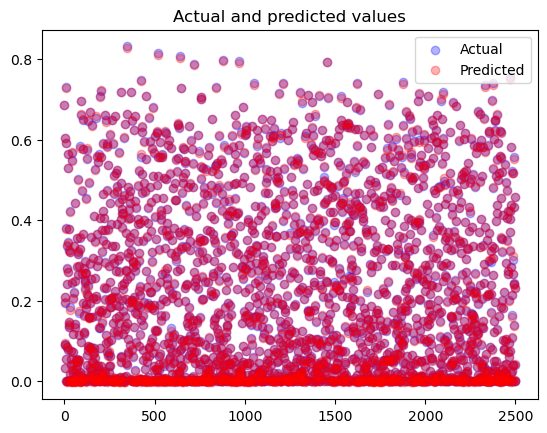

In [260]:
_, ax = plt.subplots()

ax.scatter(x = range(0, test_y.size), y=test_y, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, ypred.size), y=ypred, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.legend()
plt.show()

Text(0.01, 0.5, 'RMSE:[0.00152056]')

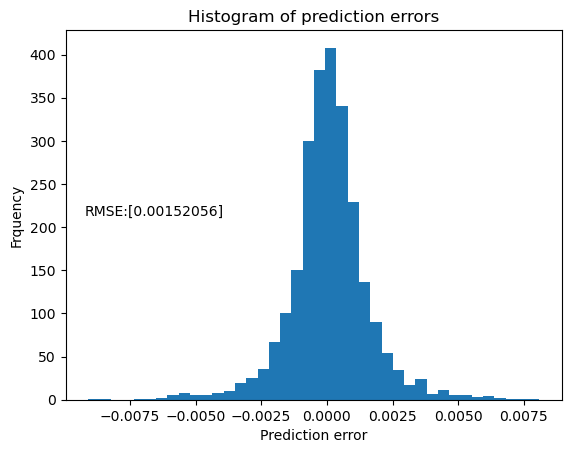

In [261]:
diff = test_y - ypred
plt.hist(diff, bins=40)
plt.title("Histogram of prediction errors")
plt.ylabel("Frquency")
plt.xlabel("Prediction error")
plt.text(0.01, 0.5, f"RMSE:{rmse}", transform=ax.transAxes)

In [272]:
SoverKbis = np.linspace(0.6, 1, num=100)
rfr = 0.03
vol = 0.1
T = 1
pred  = []

for i in range(len(SoverKbis)):
    pred.append(model.predict(np.array([[SoverKbis[i]], [T], [vol], [rfr]]).reshape(1, 4)))


1/1 [==============================] - 0s 21ms/step


ValueError: x and y can be no greater than 2D, but have shapes (100,) and (100, 1, 1)

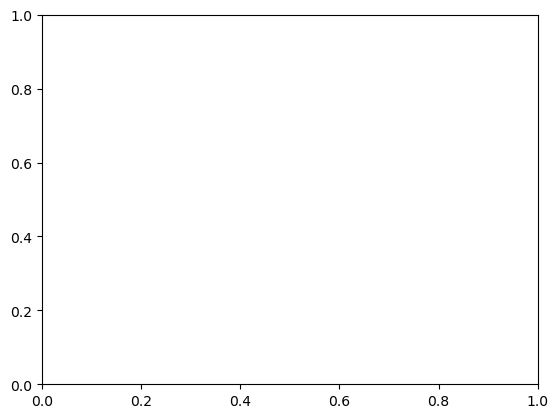

In [273]:
plt.plot(SoverKbis, pred)

In [283]:
shaped = np.array(pred).reshape(100)

In [284]:
shaped

array([0.00029827, 0.00028939, 0.00027119, 0.00025519, 0.00023919,
       0.00022319, 0.00021046, 0.00021864, 0.00022881, 0.00023685,
       0.0002764 , 0.00031611, 0.00035467, 0.00038313, 0.00040297,
       0.00042123, 0.00044459, 0.00047075, 0.00050114, 0.00052674,
       0.00055377, 0.00058727, 0.00063594, 0.00069824, 0.0007573 ,
       0.00081678, 0.00085556, 0.0008666 , 0.00086727, 0.00083687,
       0.00080815, 0.00078153, 0.00075306, 0.00072223, 0.00069603,
       0.00067732, 0.00066341, 0.00064786, 0.00063077, 0.00061389,
       0.00059644, 0.00058244, 0.00059182, 0.00060618, 0.00063038,
       0.00066605, 0.00073084, 0.0008185 , 0.00092415, 0.00108243,
       0.00125137, 0.00143636, 0.00165731, 0.00190313, 0.00219188,
       0.0025507 , 0.00292093, 0.00329494, 0.00367067, 0.00405426,
       0.0044586 , 0.00490124, 0.00540938, 0.00592329, 0.00644414,
       0.00697098, 0.00756369, 0.00815822, 0.00877776, 0.0095284 ,
       0.01040534, 0.01133434, 0.01233065, 0.01333644, 0.01435

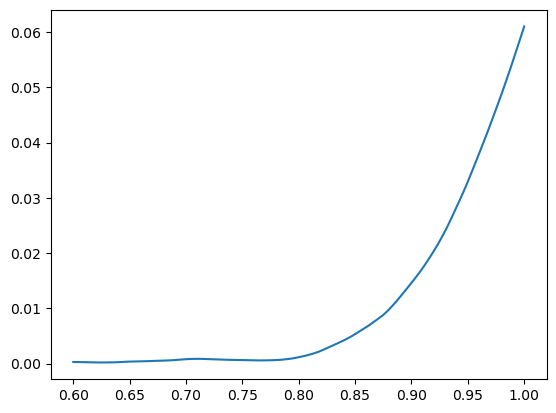

In [285]:
plt.plot(SoverKbis, shaped)